In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [3]:
import sys

sys.path.append('../..')

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

from model import FinData
from model import train_valid_split, train_valid_test_split
from model import CatboostFinModel
from datasets.categories import Oil_gas, Steel, Non_ferrous_metals, Finance, Communication

from datetime import datetime

c:\Users\Даша\Desktop\Invest-Predict main\prices-predictions\prices-predictions-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Oil and gas

Будем предсказывать акции Татнефти, включив в качестве признаков свечи других акций по категории Oil and gas

In [3]:
dfs = []
numerics = []
cats = []
names = ['Tatneft', 'Bashneft', 'Gazprom', 'Lukoil', 'Novatek', 'Rosneft']
target_name = "Tatneft"
start_date = datetime(2024, 1, 1)

for name in names:
    data = FinData(f"../../datasets/{name}_10_min.csv")
    data.restrict_time_down(start_date)

    windows_ma = [2, 3, 5, 7, 9, 18, 21, 28, 30, 50, 500]
    shifts_norms = [2, 3, 4, 5, 6]

    # data.insert_time_features()
    data.insert_rolling_means(windows_ma)
    data.insert_shifts_norms(shifts_norms)
    data.insert_exp_rolling_means(windows_ma)

    data.df.set_index('utc', inplace=True)

    if name == target_name:
        data.make_binary_class_target(target_name="direction_binary")
    else:
        data.df.rename({feature: feature + '_' + name for feature in data.df.columns}, axis=1, inplace=True)
        data.numeric_features = [feature + '_' + name for feature in data.numeric_features]
        data.cat_features = [feature + '_' + name for feature in data.cat_features]

    dfs.append(data.df)
    numerics += data.numeric_features
    cats += data.cat_features

joint_data = FinData(pd.concat(dfs, axis=1).reset_index())
joint_data.numeric_features = numerics
joint_data.cat_features = cats

In [4]:
numeric = joint_data.get_numeric_features()
cat = joint_data.get_cat_features()

X_train, X_val, y_train, y_val = train_valid_split(data=joint_data.df, 
                                                   year=2024, month=11, day=1, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [19]:
args = {"iterations" : 500, 
        "depth" : 5, 
        "use_best_model" : True, 
        "verbose" : 50,
        "l2_leaf_reg" : 200,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 50}

In [21]:
model = CatboostFinModel(args=args)


model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.optuna_choose_params({"learning_rate" : None, 
                            "l2_leaf_reg" : {"low" : 3, "high" : 500}, 
                            "depth" : {"low" : 3, "high" : 6}}, number_of_trials=100, verbose=False, n_warmup_steps=10)


[I 2025-02-05 16:24:25,275] A new study created in RDB with name: no-name-9d066159-3636-4490-b174-f094d88cbd3d
c:\Users\Даша\Desktop\Invest-Predict main\prices-predictions\examples\beb\../..\model\model.py:260: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, metric=args["eval_metric"])
[I 2025-02-05 16:24:29,224] Trial 0 finished with value: 0.6066677352139765 and parameters: {'l2_leaf_reg': 357, 'depth': 3}. Best is trial 0 with value: 0.6066677352139765.
[I 2025-02-05 16:24:53,092] Trial 1 finished with value: 0.6138804295560186 and parameters: {'l2_leaf_reg': 202, 'depth': 3}. Best is trial 1 with value: 0.6138804295560186.
[I 2025-02-05 16:25:00,593] Trial 2 finished with value: 0.6058663247315275 and parameters: {'l2_leaf_reg': 164, 'depth': 5}. Best is trial 1 with value: 0.6138804295560186.
[I 2025-02-05 16:25:17,088] Trial 3 finished with value: 0.60

In [24]:
args = {"iterations" : 5000, 
        "depth" : 6, 
        "use_best_model" : True, 
        "verbose" : 50,
        "l2_leaf_reg" : 71,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

In [25]:
# before optuna accuracy 0.62 on iteration 562
model = CatboostFinModel(args = args)

model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.fit()

0:	learn: 0.6032757	test: 0.5975317	best: 0.5975317 (0)	total: 68.7ms	remaining: 5m 43s
50:	learn: 0.6284888	test: 0.6085911	best: 0.6085911 (50)	total: 3.31s	remaining: 5m 21s
100:	learn: 0.6338441	test: 0.6114762	best: 0.6122776 (66)	total: 6.25s	remaining: 5m 2s
150:	learn: 0.6427957	test: 0.6061869	best: 0.6122776 (66)	total: 9.03s	remaining: 4m 50s
200:	learn: 0.6524900	test: 0.6074691	best: 0.6122776 (66)	total: 11.8s	remaining: 4m 42s
250:	learn: 0.6605035	test: 0.6108351	best: 0.6122776 (66)	total: 14.7s	remaining: 4m 37s
300:	learn: 0.6692596	test: 0.6079500	best: 0.6124379 (255)	total: 17.8s	remaining: 4m 37s
350:	learn: 0.6787585	test: 0.6077897	best: 0.6124379 (255)	total: 20.8s	remaining: 4m 34s
400:	learn: 0.6867719	test: 0.6095528	best: 0.6124379 (255)	total: 23.8s	remaining: 4m 33s
450:	learn: 0.6977953	test: 0.6116365	best: 0.6137201 (439)	total: 27.3s	remaining: 4m 35s
500:	learn: 0.7094832	test: 0.6106748	best: 0.6140407 (476)	total: 30.7s	remaining: 4m 35s
550:	lear

In [27]:
joint_data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'ma_2', 'close_normed_ma_2', 'low_normed_ma_2',
       ...
       'ema_21_Rosneft', 'close_normed_ema_21_Rosneft', 'ema_28_Rosneft',
       'close_normed_ema_28_Rosneft', 'ema_30_Rosneft',
       'close_normed_ema_30_Rosneft', 'ema_50_Rosneft',
       'close_normed_ema_50_Rosneft', 'ema_500_Rosneft',
       'close_normed_ema_500_Rosneft'],
      dtype='object', length=553)

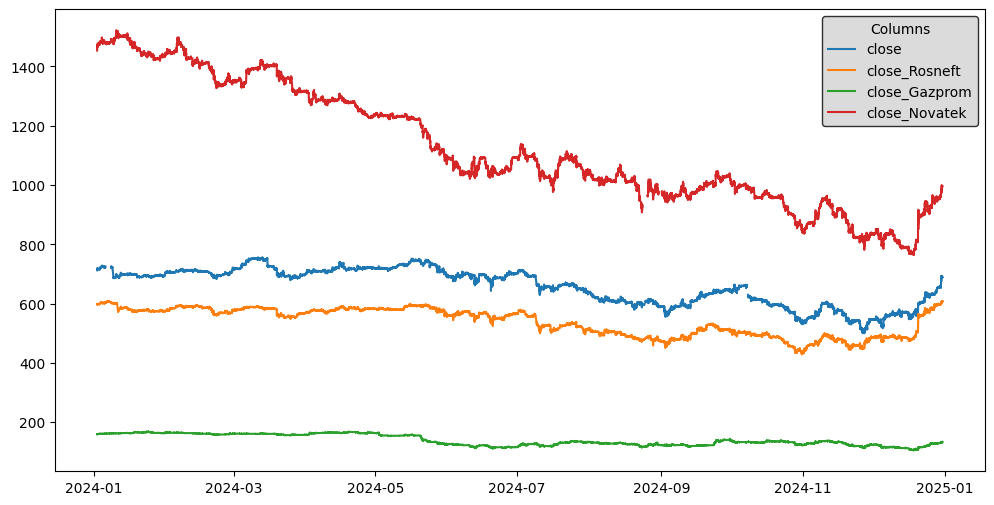

In [34]:
joint_data.visualize_time_frame(datetime_start=dt.datetime(2024, 1, 1), 
                          datetime_end=dt.datetime(2024, 12, 31), 
                          columns=["close", "close_Rosneft", "close_Gazprom", "close_Novatek"])

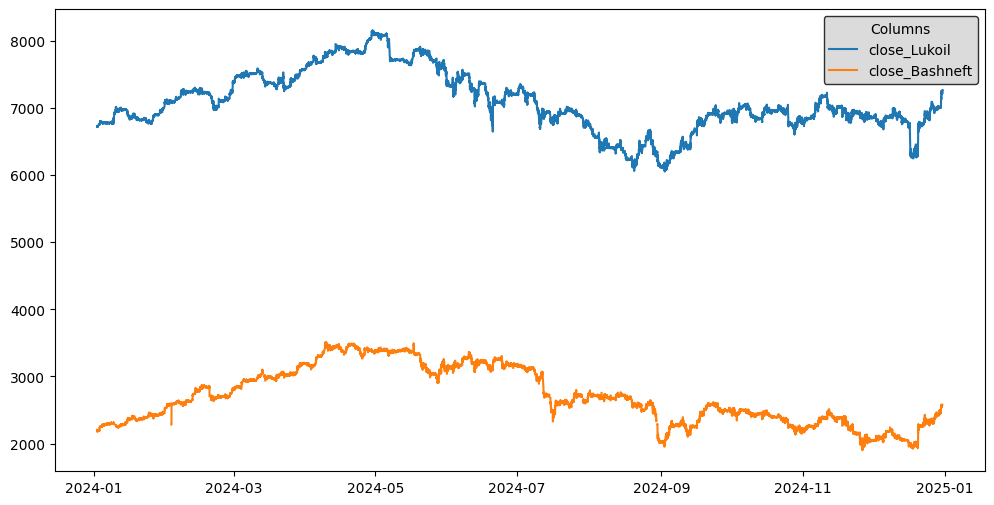

In [32]:
joint_data.visualize_time_frame(datetime_start=dt.datetime(2024, 1, 1), 
                          datetime_end=dt.datetime(2024, 12, 31), 
                          columns=["close_Lukoil", "close_Bashneft"])

6 месяцев: 4 трейн, 1 вал, 1 тест

In [36]:
dfs = []
numerics = []
cats = []
names = ['Tatneft', 'Bashneft', 'Gazprom', 'Lukoil', 'Novatek', 'Rosneft']
target_name = "Tatneft"
start_date = datetime(2024, 7, 1)

for name in names:
    data = FinData(f"../../datasets/{name}_10_min.csv")
    data.restrict_time_down(start_date)

    windows_ma = [2, 3, 5, 7, 9, 18, 21, 28, 30, 50, 500]
    shifts_norms = [2, 3, 4, 5, 6]

    # data.insert_time_features()
    data.insert_rolling_means(windows_ma)
    data.insert_shifts_norms(shifts_norms)
    data.insert_exp_rolling_means(windows_ma)

    data.df.set_index('utc', inplace=True)

    if name == target_name:
        data.make_binary_class_target(target_name="direction_binary")
    else:
        data.df.rename({feature: feature + '_' + name for feature in data.df.columns}, axis=1, inplace=True)
        data.numeric_features = [feature + '_' + name for feature in data.numeric_features]
        data.cat_features = [feature + '_' + name for feature in data.cat_features]

    dfs.append(data.df)
    numerics += data.numeric_features
    cats += data.cat_features

joint_data = FinData(pd.concat(dfs, axis=1).reset_index())
joint_data.numeric_features = numerics
joint_data.cat_features = cats

In [ ]:
numeric = joint_data.get_numeric_features()
cat = joint_data.get_cat_features()

X_train, X_val, X_test, y_train, y_val, y_test= train_valid_test_split(data=joint_data.df, 
                                                   test_start_data=datetime(2024, 12, 1),
                                                   test_ticks=2970, val_ticks=2970,
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [49]:
model = CatboostFinModel(args = args)

model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.fit()

0:	learn: 0.6066535	test: 0.6013468	best: 0.6013468 (0)	total: 77.8ms	remaining: 6m 28s
50:	learn: 0.6381970	test: 0.6010101	best: 0.6030303 (11)	total: 2.27s	remaining: 3m 40s
100:	learn: 0.6515556	test: 0.5989899	best: 0.6030303 (11)	total: 4.43s	remaining: 3m 34s
150:	learn: 0.6658623	test: 0.6030303	best: 0.6030303 (11)	total: 6.49s	remaining: 3m 28s
200:	learn: 0.6776696	test: 0.6033670	best: 0.6043771 (186)	total: 8.57s	remaining: 3m 24s
250:	learn: 0.6936137	test: 0.6060606	best: 0.6080808 (247)	total: 10.7s	remaining: 3m 22s
300:	learn: 0.7075756	test: 0.6063973	best: 0.6080808 (247)	total: 12.9s	remaining: 3m 21s
350:	learn: 0.7211066	test: 0.6080808	best: 0.6101010 (324)	total: 15.3s	remaining: 3m 22s
400:	learn: 0.7373093	test: 0.6074074	best: 0.6107744 (395)	total: 17.7s	remaining: 3m 22s
450:	learn: 0.7525640	test: 0.6050505	best: 0.6107744 (395)	total: 20.1s	remaining: 3m 22s
500:	learn: 0.7667845	test: 0.6084175	best: 0.6107744 (395)	total: 22.5s	remaining: 3m 22s
550:	l

In [56]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.64      0.70      0.67      1720\n           1       0.52      0.46      0.49      1250\n\n    accuracy                           0.60      2970\n   macro avg       0.58      0.58      0.58      2970\nweighted avg       0.59      0.60      0.59      2970\n'

#### Finance

In [65]:
names = ['Sber', 'T', 'Moex', 'VTB']

dfs = []
numerics = []
cats = []
target_name = "Sber"
start_date = datetime(2024, 7, 1)

for name in names:
    data = FinData(f"../../datasets/{name}_10_min.csv")
    data.restrict_time_down(start_date)

    windows_ma = [2, 3, 5, 7, 9, 18, 21, 28, 30, 50]
    shifts_norms = [2, 3, 4, 5, 6]

    # data.insert_time_features()
    data.insert_rolling_means(windows_ma)
    data.insert_shifts_norms(shifts_norms)
    data.insert_exp_rolling_means(windows_ma)

    data.df.set_index('utc', inplace=True)

    if name == target_name:
        data.make_binary_class_target(target_name="direction_binary")
    else:
        data.df.rename({feature: feature + '_' + name for feature in data.df.columns}, axis=1, inplace=True)
        data.numeric_features = [feature + '_' + name for feature in data.numeric_features]
        data.cat_features = [feature + '_' + name for feature in data.cat_features]

    dfs.append(data.df)
    numerics += data.numeric_features
    cats += data.cat_features

joint_data_finance = FinData(pd.concat(dfs, axis=1).reset_index())
joint_data_finance.numeric_features = numerics
joint_data_finance.cat_features = cats

In [66]:
joint_data_finance.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'ma_2', 'close_normed_ma_2', 'low_normed_ma_2',
       ...
       'ema_18_VTB', 'close_normed_ema_18_VTB', 'ema_21_VTB',
       'close_normed_ema_21_VTB', 'ema_28_VTB', 'close_normed_ema_28_VTB',
       'ema_30_VTB', 'close_normed_ema_30_VTB', 'ema_50_VTB',
       'close_normed_ema_50_VTB'],
      dtype='object', length=345)

##### Посмотрим на свечи

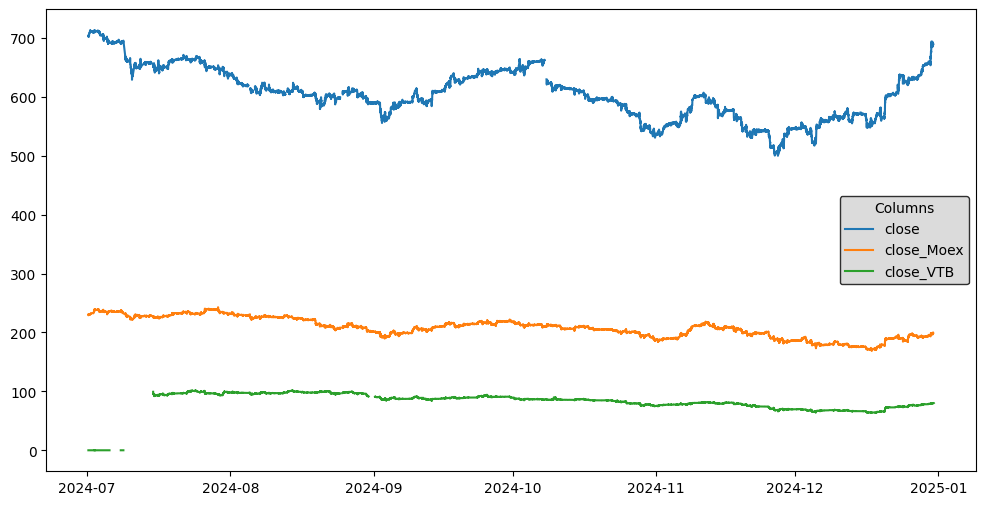

In [63]:
joint_data_finance.visualize_time_frame(datetime_start=dt.datetime(2024, 7, 1), 
                          datetime_end=dt.datetime(2024, 12, 31), 
                          columns=["close", "close_Moex", "close_VTB"])

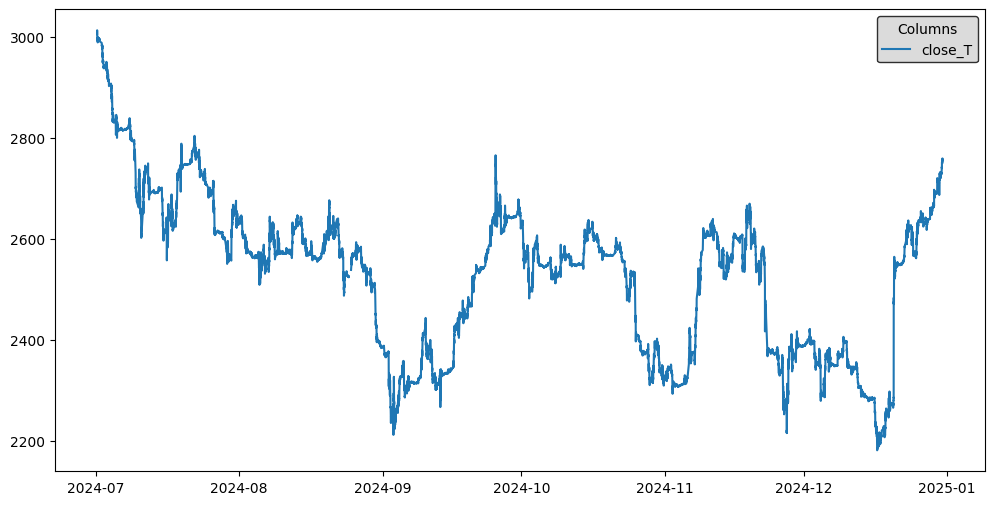

In [67]:
joint_data_finance.visualize_time_frame(datetime_start=dt.datetime(2024, 7, 1), 
                          datetime_end=dt.datetime(2024, 12, 31), 
                          columns=["close_T"])

In [68]:
args = {"iterations" : 500, 
        "depth" : 5, 
        "use_best_model" : True, 
        "verbose" : 50,
        "l2_leaf_reg" : 200,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 50}

model = CatboostFinModel(args=args)

model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.optuna_choose_params({"learning_rate" : None, 
                            "l2_leaf_reg" : {"low" : 3, "high" : 500}, 
                            "depth" : {"low" : 3, "high" : 6}}, number_of_trials=100, verbose=False, n_warmup_steps=10)

[I 2025-02-05 17:56:10,736] A new study created in RDB with name: no-name-9c5a31cc-596f-45b6-807a-644fd2b33061
c:\Users\Даша\Desktop\Invest-Predict main\prices-predictions\examples\beb\../..\model\model.py:262: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, metric=args["eval_metric"])
[I 2025-02-05 17:56:13,865] Trial 0 finished with value: 0.6013468013468013 and parameters: {'l2_leaf_reg': 250, 'depth': 3}. Best is trial 0 with value: 0.6013468013468013.
[I 2025-02-05 17:56:19,268] Trial 1 finished with value: 0.6063973063973064 and parameters: {'l2_leaf_reg': 229, 'depth': 6}. Best is trial 1 with value: 0.6063973063973064.
[I 2025-02-05 17:56:21,057] Trial 2 finished with value: 0.5993265993265994 and parameters: {'l2_leaf_reg': 419, 'depth': 3}. Best is trial 1 with value: 0.6063973063973064.
[I 2025-02-05 17:56:23,141] Trial 3 finished with value: 0.59

In [69]:
args = {"iterations" : 5000, 
        "depth" : 6, 
        "use_best_model" : True, 
        "verbose" : 50,
        "l2_leaf_reg" : 350,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

numeric = joint_data.get_numeric_features()
cat = joint_data.get_cat_features()

X_train, X_val, X_test, y_train, y_val, y_test= train_valid_test_split(data=joint_data.df, 
                                                   test_start_data=datetime(2024, 12, 1),
                                                   test_ticks=2970, val_ticks=2970,
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args = args)

model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.fit()

0:	learn: 0.6066535	test: 0.6013468	best: 0.6013468 (0)	total: 61ms	remaining: 5m 5s
50:	learn: 0.6335430	test: 0.6030303	best: 0.6053872 (49)	total: 2.58s	remaining: 4m 10s
100:	learn: 0.6389727	test: 0.6023569	best: 0.6060606 (82)	total: 4.98s	remaining: 4m 1s
150:	learn: 0.6456951	test: 0.6030303	best: 0.6060606 (82)	total: 7.22s	remaining: 3m 51s
200:	learn: 0.6543135	test: 0.6006734	best: 0.6060606 (82)	total: 9.38s	remaining: 3m 43s
250:	learn: 0.6631044	test: 0.6030303	best: 0.6063973 (229)	total: 11.5s	remaining: 3m 38s
300:	learn: 0.6694820	test: 0.6080808	best: 0.6087542 (296)	total: 13.9s	remaining: 3m 36s
350:	learn: 0.6773248	test: 0.6124579	best: 0.6124579 (350)	total: 16.3s	remaining: 3m 35s
400:	learn: 0.6887874	test: 0.6074074	best: 0.6124579 (350)	total: 18.7s	remaining: 3m 34s
450:	learn: 0.6988710	test: 0.6097643	best: 0.6124579 (350)	total: 20.9s	remaining: 3m 31s
500:	learn: 0.7080066	test: 0.6138047	best: 0.6138047 (500)	total: 23.1s	remaining: 3m 27s
550:	learn:

In [70]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.65      0.72      0.68      1720\n           1       0.54      0.46      0.50      1250\n\n    accuracy                           0.61      2970\n   macro avg       0.60      0.59      0.59      2970\nweighted avg       0.60      0.61      0.60      2970\n'

#### Oil and gas 2

Будем предсказывать акции Татнефти, включив в качестве признаков углы между ценой закрытия свечей Татнефти и ценами закрытия других акций по категории Oil and gas

In [ ]:
dfs = []
numerics = []
cats = []
names = ['Tatneft', 'Bashneft', 'Gazprom', 'Lukoil', 'Novatek', 'Rosneft']
target_name = "Tatneft"
start_date = datetime(2024, 1, 1)

for name in names:
    data = FinData(f"../../datasets/{name}_10_min.csv")
    data.restrict_time_down(start_date)

    if name == target_name:
        windows_ma = [2, 3, 5, 7, 9, 18, 21, 28, 30, 50, 500]
        shifts_norms = [3, 6, 18]
        # data.insert_time_features()
        data.insert_rolling_means(windows_ma)
        data.insert_shifts_norms(shifts_norms)
        data.insert_exp_rolling_means(windows_ma)
        data.make_binary_class_target(target_name="direction_binary")

    data.df.set_index('utc', inplace=True)

    if name != target_name:
        data.df.rename({feature: feature + '_' + name for feature in data.df.columns}, axis=1, inplace=True)
        data.numeric_features = [feature + '_' + name for feature in data.numeric_features]
        data.cat_features = [feature + '_' + name for feature in data.cat_features]

    #data.insert_angle
    dfs.append(data.df)
    numerics += data.numeric_features
    cats += data.cat_features

joint_data = FinData(pd.concat(dfs, axis=1).reset_index())

# добавляем углы 
for name in names:
    if name != target_name:
        joint_data.insert_angle(name)
        joint_data.insert_angle_ln(name)
        numerics += [f'angle_{name}', f'angle_ln_{name}']

joint_data.numeric_features = numerics
joint_data.cat_features = cats

In [19]:
joint_data.df.sample()

,utc,open,close,high,low,volume,direction_binary,ma_2,close_normed_ma_2,low_normed_ma_2,...,angle_Bashneft,angle_ln_Bashneft,angle_Gazprom,angle_ln_Gazprom,angle_Lukoil,angle_ln_Lukoil,angle_Novatek,angle_ln_Novatek,angle_Rosneft,angle_ln_Rosneft
28437,2024-11-29 15:10:00,544.9,546.3,546.7,544.9,80314.0,1,542.85,1.006355,1.003776,...,0.950547,0.002566,0.93055,0.002405,-0.440396,0.001765,0.275806,0.001601,0.705568,0.002045


In [25]:
numeric = joint_data.get_numeric_features()
cat = joint_data.get_cat_features()

args = {"iterations" : 5000, 
        "depth" : 6, 
        "use_best_model" : True, 
        "verbose" : 50,
        "l2_leaf_reg" : 350,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}


model = CatboostFinModel(args=args)

model.test_weekly(df=joint_data.df, start_dt=datetime(2024, 7, 1), proportion=[3, 1, 1], cat=cat, num=numeric)

c:\Users\Даша\Desktop\Invest-Predict main\prices-predictions\examples\beb\../..\model\model.py:388: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df[df['utc'] >= start_dt][df['utc'] <= end_dt].copy()


0:	learn: 0.6113074	test: 0.6115726	best: 0.6115726 (0)	total: 15.7ms	remaining: 1m 18s
50:	learn: 0.6232452	test: 0.6221713	best: 0.6224577 (46)	total: 821ms	remaining: 1m 19s
100:	learn: 0.6297393	test: 0.6224577	best: 0.6247494 (90)	total: 1.48s	remaining: 1m 11s
150:	learn: 0.6366154	test: 0.6256087	best: 0.6281868 (118)	total: 2.14s	remaining: 1m 8s
200:	learn: 0.6489352	test: 0.6238900	best: 0.6281868 (118)	total: 2.82s	remaining: 1m 7s
250:	learn: 0.6578168	test: 0.6224577	best: 0.6281868 (118)	total: 3.46s	remaining: 1m 5s
300:	learn: 0.6644065	test: 0.6218848	best: 0.6281868 (118)	total: 4.12s	remaining: 1m 4s
350:	learn: 0.6757712	test: 0.6213119	best: 0.6281868 (118)	total: 4.78s	remaining: 1m 3s
400:	learn: 0.6818833	test: 0.6201661	best: 0.6281868 (118)	total: 5.44s	remaining: 1m 2s
450:	learn: 0.6908605	test: 0.6215984	best: 0.6281868 (118)	total: 6.08s	remaining: 1m 1s
500:	learn: 0.6992646	test: 0.6207390	best: 0.6281868 (118)	total: 6.72s	remaining: 1m
550:	learn: 0.70

0.5869501893387707

In [9]:
model.get_top_imp_features(20)

1.1998816449973242 close_normed_ema_30
1.388383686205115 close_normed_ma_50
1.4309021393633088 high_normed_ma_2
1.4535824836255842 close_high_norms_3
1.4759298978854751 close_normed_ma_9
1.500829479976527 high_normed_ma_3
1.5304177264204382 volume_Lukoil
1.5836685371496402 close_normed_ma_28
1.7171422806878502 close_normed_ma_2
1.7256309171363968 high_normed_ma_5
1.9977614398774906 angle_Gazprom
3.465782879817784 close_normed_ma_3
3.7604498599576996 close_normed_ema_18
4.1736863633447205 close_normed_ema_5
4.401008832632484 close_normed_ema_3
5.049984654720192 volume_Rosneft
5.6625273705061465 volume_Novatek
6.055671836031639 volume
6.549070143660275 close_normed_ema_2
9.7829547682391 volume_Gazprom


array(['close_normed_ema_30', 'close_normed_ma_50', 'high_normed_ma_2',
       'close_high_norms_3', 'close_normed_ma_9', 'high_normed_ma_3',
       'volume_Lukoil', 'close_normed_ma_28', 'close_normed_ma_2',
       'high_normed_ma_5', 'angle_Gazprom', 'close_normed_ma_3',
       'close_normed_ema_18', 'close_normed_ema_5', 'close_normed_ema_3',
       'volume_Rosneft', 'volume_Novatek', 'volume', 'close_normed_ema_2',
       'volume_Gazprom'], dtype='<U20')

### Test within categories

In [ ]:
names, test_accuracies = model.test_within_category(Communication, start_dt=datetime(2024, 7, 1), proportion=[7, 1, 1])

[Text(0, 0, '0.621566'),
 Text(0, 0, '0.617418'),
 Text(0, 0, '0.635044'),
 Text(0, 0, '0.619492'),
 Text(0, 0, '0.593053'),
 Text(0, 0, '0.629342')]

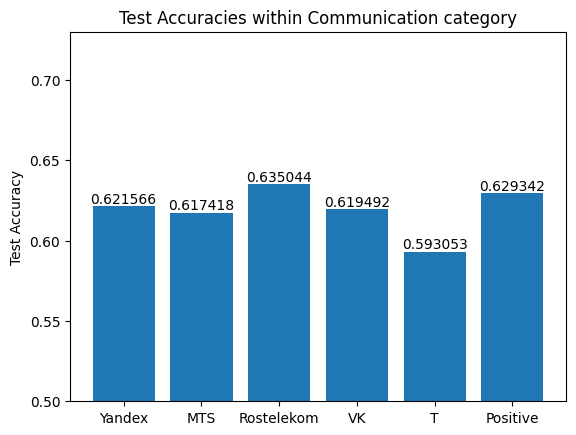

In [54]:
fig, ax = plt.subplots()
bar_container = ax.bar(names, test_accuracies)
ax.set(ylabel='Test Accuracy', title='Test Accuracies within Communication category', ylim=(0.5, 0.73))
ax.bar_label(bar_container)

##### что происходит с полиметалом

In [24]:
poly_data = FinData(f"../../datasets/Polymetal_10_min.csv")
poly_data.make_binary_class_target(target_name="direction_binary")
poly_data.restrict_time_down(months=6)

windows_ma = [2, 3, 5, 7, 9, 18, 21, 28, 30, 50, 500]

# data.insert_time_features()
poly_data.insert_rolling_means(windows_ma)
poly_data.insert_shifts_norms()
poly_data.insert_exp_rolling_means(windows_ma)

numeric = poly_data.get_numeric_features()
cat = poly_data.get_cat_features()


X_train, X_val, y_train, y_val = train_valid_split(data=poly_data.df, 
                                                   year=2024, month=11, day=1, 
                                                   numeric=numeric, cat=[], target="direction_binary")


args = {"iterations" : 5000, 
"depth" : 6, 
"use_best_model" : True, 
"verbose" : False,
"l2_leaf_reg" : 350,
"loss_function" : 'Logloss', 
"eval_metric" : 'Accuracy', 
"cat_features" : cat, 
"random_state" : 42,
"early_stopping_rounds" : 1000}

In [25]:
poly_data.df.sample()

,utc,open,close,high,low,volume,direction_binary,ma_2,close_normed_ma_2,low_normed_ma_2,...,ema_21,close_normed_ema_21,ema_28,close_normed_ema_28,ema_30,close_normed_ema_30,ema_50,close_normed_ema_50,ema_500,close_normed_ema_500
15000,2024-09-23 18:20:00,264.9,264.6,265.0,262.9,14523,1,263.5,1.004175,0.997723,...,259.905828,1.018061,258.975509,1.021718,258.748831,1.022613,257.343153,1.028199,261.595492,1.011485


In [21]:
model = CatboostFinModel(args=args)

model.set_datasets(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
model.set_features(numeric_features=numeric, cat_features=cat)

model.fit()

CatBoostError: Labels variable is empty.

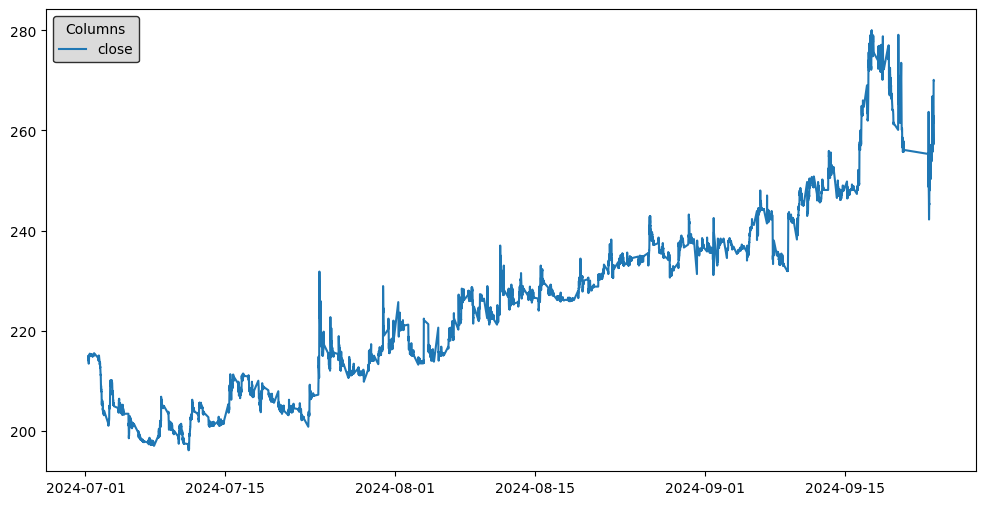

In [ ]:
poly_data.visualize_time_frame(datetime_start=dt.datetime(2024, 7, 1), 
                          datetime_end=dt.datetime(2024, 12, 31), 
                          columns=["close"])